[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/yhtang/FunFact/blob/master/docs/examples/matrix-approximation.ipynb)

# Matrix Approximation

## Install package and obtain assets if running on Google Colab

In [1]:
try:
    import google.colab
    !pip install funfact scikit-image
    !pip install -U scikit-image
    !wget https://upload.wikimedia.org/wikipedia/en/8/86/Einstein_tongue.jpg
except:
    pass

## Imports and visualization setup

In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import numpy as np
import matplotlib.pyplot as plt
import skimage as ski
import funfact as ff
from funfact import active_backend as ab

In [3]:
ff.use('jax')

In [4]:
# Alternatively,
# ff.use('torch', device='cuda')

In [5]:
ab

<backend 'JAXBackend'>

## SVD as a baseline

[Singular value decomposition](https://en.wikipedia.org/wiki/Singular_value_decomposition) generalizes the eigendecomposition of a square matrix to any rectangular matrix. It seeks to factorize a matrix $A$ as

$$A = U \Sigma V,$$

where $\Sigma$ is diagonal, and $U$ and $V$ are orthonormal matrices. The SVD-based rank-k approximation is optimal with respect to the elementwise L2 (Frobenius) norm.

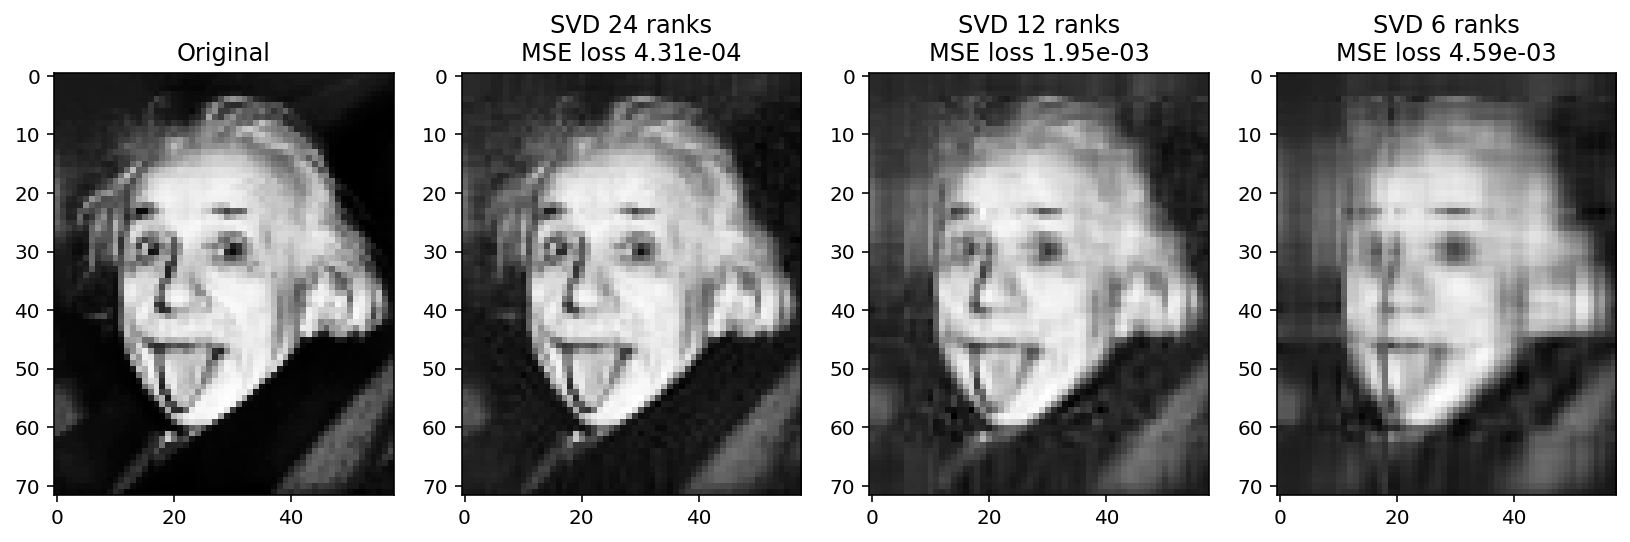

In [6]:
img = ski.transform.rescale(ski.io.imread('Einstein_tongue.jpg'), 0.25, anti_aliasing=True)
img = img**1.8  # gamma correction
target = ab.tensor(img)

ranks = [24, 12, 6]
U, S, V = np.linalg.svd(img)

fig, axs = plt.subplots(1, 4, figsize=(14, 4))
axs[0].imshow(img, cmap='Greys_r')
axs[0].set_title('Original')

for r, ax in zip(ranks, axs[1:]):
    img_compressed = ab.tensor((U[:, :r] * S[:r]) @ V[:r, :])
    ax.imshow(ab.to_numpy(img_compressed), cmap='Greys_r')
    ax.set_title('SVD {} ranks\nMSE loss {:.2e}'.format(r, ff.loss.mse(img_compressed, target)))

plt.show()

## Low-rank decomposition with gradient descent

Here, we seek the rank-$k$ approxiomation of a matrix $A_{ij} \approx \boldsymbol{u}_{ik} \boldsymbol{v}_{jk}$ using gradient descent. Interestingly, the solutions nicely coincide with those obtained from SVD.

100%|██████████| 1000/1000 [00:02<00:00, 430.31it/s]


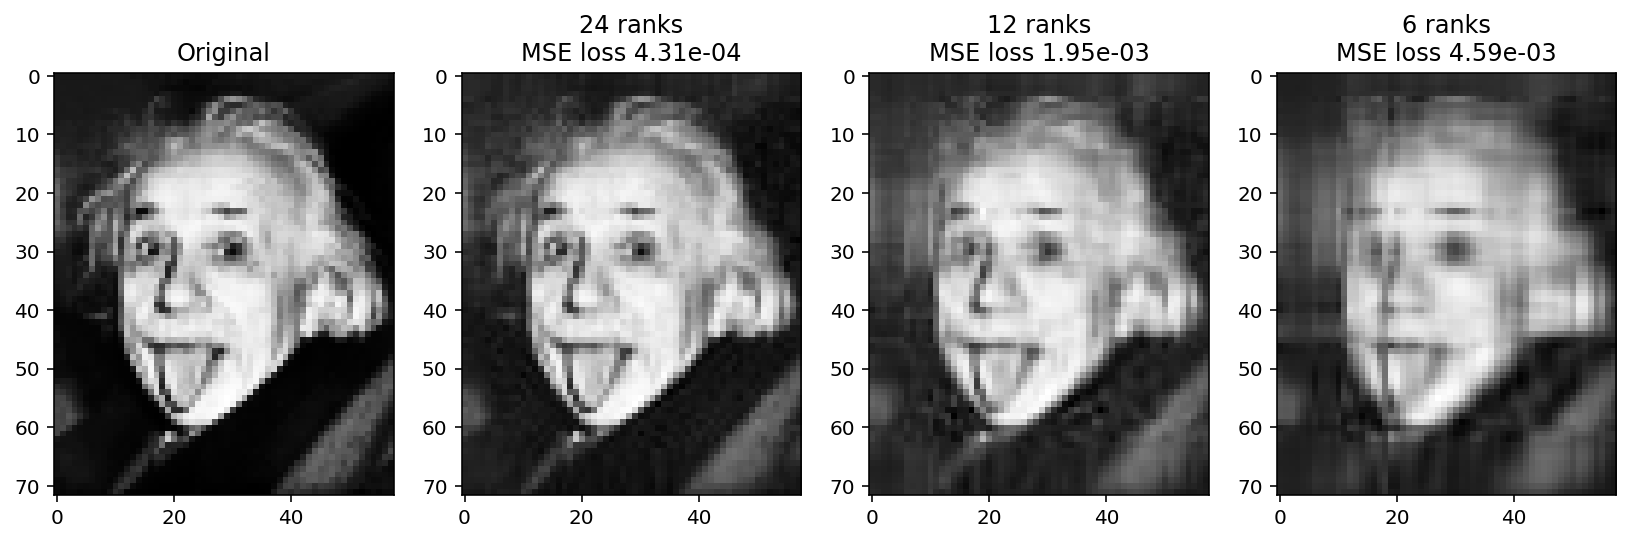

In [7]:
n, m = target.shape

fig, axs = plt.subplots(1, 4, figsize=(14, 4))
axs[0].imshow(img, cmap='Greys_r')
axs[0].set_title('Original')
fac_svd = {}

for r, ax in zip(ranks, axs[1:]):
    u = ff.tensor('u', n, r, initializer=ff.initializers.Normal)
    v = ff.tensor('v', m, r, initializer=ff.initializers.Normal)
    i, j, k = ff.indices('i, j, k')
    tsrex = u[i, k] * v[j, k]
    fac = ff.factorize(tsrex, target, lr=0.1, max_steps=1000)
    fac_svd[r] = fac
    img_compressed = fac()
    ax.imshow(ab.to_numpy(img_compressed), cmap='Greys_r')
    ax.set_title('{} ranks\nMSE loss {:.2e}'.format(r, ff.loss.mse(img_compressed, target)))

plt.show()

## Solving [RBF approximation](https://arxiv.org/abs/2106.02018) with gradient descent

Here, we demonstrate that a better approximation (in terms of the L2 norm) can be achieved with the same number of components by applying a nonlinear functional form between the factors such that $A_{ij} \approx {{\operatorname{exp}{\left(-{\left({{\boldsymbol{u}}_{{{i}}{{\widetilde{k}}}}} - {{\boldsymbol{v}}_{{{j}}{{\widetilde{k}}}}}\right)} ^ {2}\right)}}  {{\boldsymbol{a}}_{{{k}}}}} + {{\boldsymbol{b}}_{}}$. This is where  a close-form solution no longer exists due to the nonconvex and nonlinear nature of the problem. Therefore, we have to resort to using multi-replica gradient descent with random initialization to find approximate solutions.

100%|██████████| 10000/10000 [00:50<00:00, 197.83it/s]


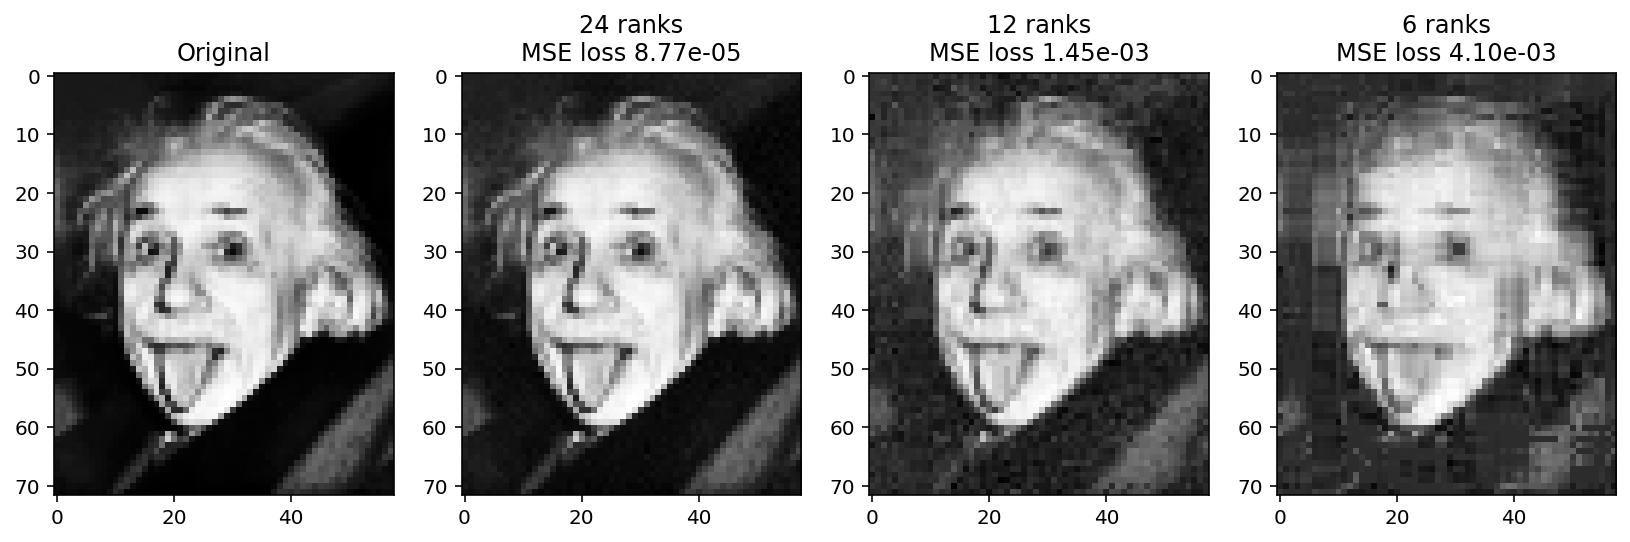

In [8]:
n, m = target.shape

fig, axs = plt.subplots(1, 4, figsize=(14, 4))
axs[0].imshow(img, cmap='Greys_r')
axs[0].set_title('Original')
fac_rbf = {}

for r, ax in zip(ranks, axs[1:]):
    u = ff.tensor('u', n, r, initializer=ff.initializers.Normal)
    v = ff.tensor('v', m, r, initializer=ff.initializers.Normal)
    a = ff.tensor('a', r, initializer=ff.initializers.VarianceScaling(scale=ab.var(target), axis=0))
    b = ff.tensor('b')
    i, j, k = ff.indices('i, j, k')
    tsrex = ff.exp(-(u[i, ~k] - v[j, ~k])**2) * a[k] + b[[]]
    fac = ff.factorize(tsrex, target, vec_size=16, lr=0.05, max_steps=10000)
    fac_rbf[r] = fac
    img_compressed = fac()
    ax.imshow(ab.to_numpy(img_compressed), cmap='Greys_r')
    ax.set_title('{} ranks\nMSE loss {:.2e}'.format(r, ff.loss.mse(img_compressed, target)))

plt.show()

## Side-by-side comparison

We see that the RBF approximation leads to better quality across the range of compression ratios. Although it takes a higher cost to solve, the RBF approximation can be beneficial in situations (e.g. data archive, object store, etc.) where the same piece of matrix data is saved once and then loaded repeatedly.

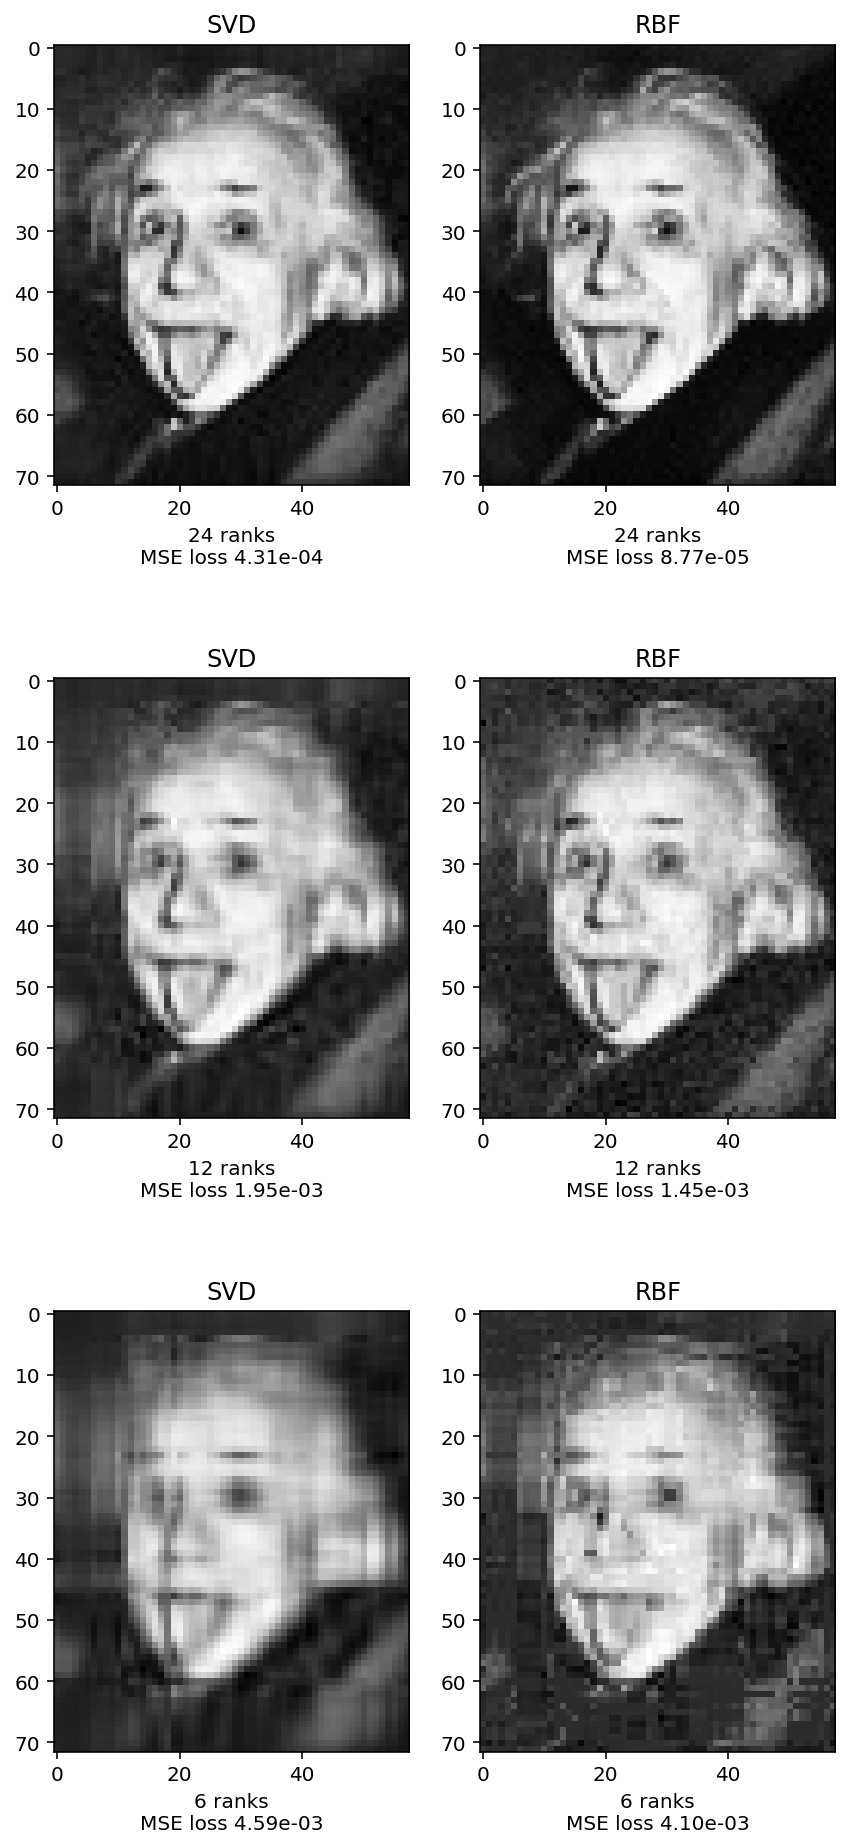

In [9]:
fig, axs = plt.subplots(len(ranks), 2, figsize=(7, 5.5 * len(ranks)))

for r, axrow in zip(ranks, axs):
    for fac, ax in zip((fac_svd[r], fac_rbf[r]), axrow):
        ax.imshow(ab.to_numpy(fac()), cmap='Greys_r')
        ax.set_xlabel('{} ranks\nMSE loss {:.2e}'.format(r, ff.loss.mse(fac(), target)))

    axrow[0].set_title('SVD')
    axrow[1].set_title('RBF')

plt.show()

---